# Basic_Junction_Center_Network

### Description:

Find junction parameters given centered junctions.

Findings:

- Doesn't work well. CNNs struggle with learing angles, especially when permutations matter.

In [1]:
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from torchsummary import summary

In [2]:
# Load data

data_folder = 'foj_data/grayscale_junctions/'

with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
    data = pickle.load(f)

wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']

In [3]:
# Create data structure with optional transforms

class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, centers, boundaries, transform=None):
        self.images = images
        self.centers = centers
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index].unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        center = params[index].squeeze()
        boundary = boundaries[index]

        return image, center, boundary

    def __len__(self):
        return len(self.images)
    
    
# transform = transforms.Compose([
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

junction_center_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=transform)

In [4]:
data_size = len(wedges)

train_dataset, test_dataset = torch.utils.data.random_split(junction_center_data, [int(data_size*.9), int(data_size*.1)], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

## Part 1: Start by only trying to find the vertex of a junction given its image

In [156]:
class centerNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128, 128)   
        self.fc2 = nn.Linear(128, 2)   
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = F.relu(self.maxpool(x))
        x = self.conv6(x)
        x = F.relu(self.maxpool(x))
        x = x.view(-1,128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = 2*torch.sigmoid(x)-1
        
        out = x
        
        return out

In [157]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = centerNet()
model = model.to(device)

summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
        MaxPool2d-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 128, 2, 2]         147,584
        MaxPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                  [-1, 128]          16,512
           Linear-14                   

In [158]:
# criterion = nn.MSELoss()

def square_dist_loss(output, target):
    loss = torch.sqrt(torch.sum((output - target)**2))
    return loss

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [161]:
n_epochs = 200

model.train();

# loss_over_time = [] # to track the loss as the network trains
# test_loss_over_time = []

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0.0

    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels
        inputs, labels, _ = data
    
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()

        # forward pass to get outputs
        outputs = model(inputs)

        # calculate the loss
#         loss = criterion(outputs, labels)

        loss = square_dist_loss(outputs,labels[:,3:])

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # print loss statistics
        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

#         if batch_i % 1000 == 999:    # print every 1000 batches
#             avg_loss = running_loss/1000
#             # record and print the avg loss over the 1000 batches
#             loss_over_time.append(avg_loss)
#             print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
#             running_loss = 0.0

    # Calculate test data loss:
    with torch.no_grad():
        # log scalars
        for batch_i, data in enumerate(test_loader):
            
            inputs_test, labels_test, _ = data
            inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)           
            pred_test = model(inputs_test)
            test_loss = square_dist_loss(pred_test,labels_test[:,3:])
            test_loss_over_time.append(test_loss)

    # Calculate model loss:
    avg_loss = running_loss
    # record and print the avg loss over the 1000 batches
    loss_over_time.append(avg_loss)
    print('Epoch: {}, Avg. Loss: {}, Test Loss: {}'.format(epoch + 1, avg_loss, test_loss))
    

print('Finished Training')

Epoch: 1, Avg. Loss: 1160.546431183815, Test Loss: 18.012924194335938
Epoch: 2, Avg. Loss: 1157.9836449623108, Test Loss: 17.89447593688965
Epoch: 3, Avg. Loss: 1113.5727199316025, Test Loss: 16.828893661499023
Epoch: 4, Avg. Loss: 998.5702340602875, Test Loss: 13.971644401550293
Epoch: 5, Avg. Loss: 835.6496633887291, Test Loss: 11.528054237365723
Epoch: 6, Avg. Loss: 688.9310245513916, Test Loss: 10.37148380279541
Epoch: 7, Avg. Loss: 573.1689695715904, Test Loss: 9.314657211303711
Epoch: 8, Avg. Loss: 501.22595036029816, Test Loss: 9.094123840332031
Epoch: 9, Avg. Loss: 443.44432830810547, Test Loss: 7.65187931060791
Epoch: 10, Avg. Loss: 402.90243366360664, Test Loss: 6.358292102813721
Epoch: 11, Avg. Loss: 365.413605093956, Test Loss: 6.33572244644165
Epoch: 12, Avg. Loss: 338.46406531333923, Test Loss: 5.506793975830078
Epoch: 13, Avg. Loss: 295.6548825800419, Test Loss: 5.677399635314941
Epoch: 14, Avg. Loss: 273.75162425637245, Test Loss: 4.7952117919921875
Epoch: 15, Avg. Loss

Epoch: 117, Avg. Loss: 33.168948559090495, Test Loss: 2.2196872234344482
Epoch: 118, Avg. Loss: 34.62166594713926, Test Loss: 2.1944947242736816
Epoch: 119, Avg. Loss: 33.87443606182933, Test Loss: 2.091430425643921
Epoch: 120, Avg. Loss: 31.98945166170597, Test Loss: 2.2495408058166504
Epoch: 121, Avg. Loss: 33.745858723297715, Test Loss: 2.211676597595215
Epoch: 122, Avg. Loss: 32.381484009325504, Test Loss: 2.125915288925171
Epoch: 123, Avg. Loss: 32.526155199855566, Test Loss: 2.107975482940674
Epoch: 124, Avg. Loss: 32.373015601187944, Test Loss: 2.3199167251586914
Epoch: 125, Avg. Loss: 32.96341425180435, Test Loss: 2.166299343109131
Epoch: 126, Avg. Loss: 32.860773138701916, Test Loss: 2.2432987689971924
Epoch: 127, Avg. Loss: 32.876261699944735, Test Loss: 2.1457724571228027
Epoch: 128, Avg. Loss: 31.81033089198172, Test Loss: 2.187781810760498
Epoch: 129, Avg. Loss: 31.965481150895357, Test Loss: 2.095266103744507
Epoch: 130, Avg. Loss: 31.39029846712947, Test Loss: 2.12793636

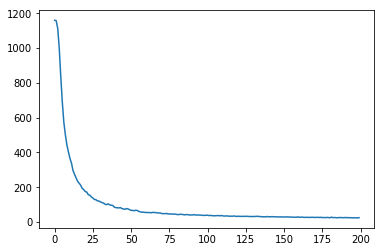

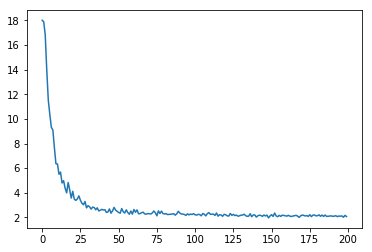

In [162]:
plt.figure()
plt.plot(loss_over_time)


plt.figure()
plt.plot(test_loss_over_time)



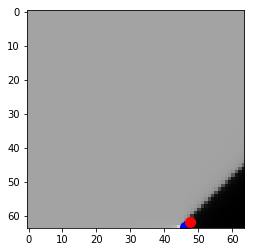

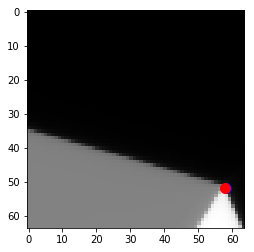

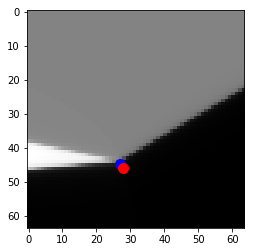

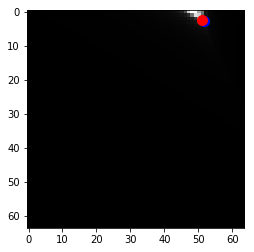

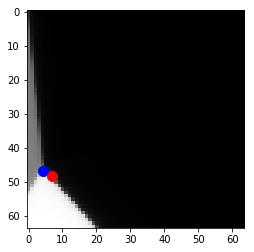

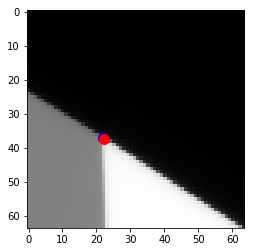

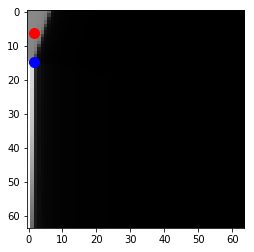

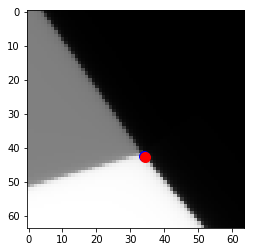

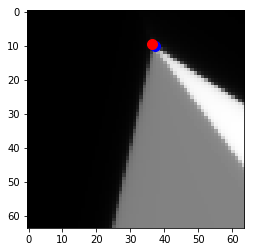

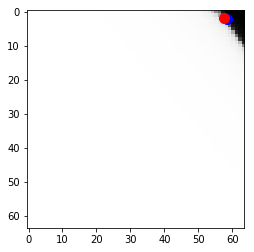

In [164]:
# What should the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, labels, _ = data
    
    inputs, labels = inputs.to(device), labels.to(device)

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()*32+32
    
    gt = labels.cpu().squeeze()*32 + 32
    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')
    plt.plot(gt[ii][3],gt[ii][4],'bo',markersize=10)
    plt.plot(outputs[ii][0],outputs[ii][1],'ro',markersize=10)
    
#     if batch_i == 10:
#         sys.quit()



### Visualize the output of each layer to see what the network is learning

In [165]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


Total convolution layers: 6
conv_layers


In [179]:
outputs = []
names = []

image = train_dataset[0][0].unsqueeze(0).to(device)

for layer in conv_layers[0:]:
    
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

torch.Size([1, 32, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])


In [180]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


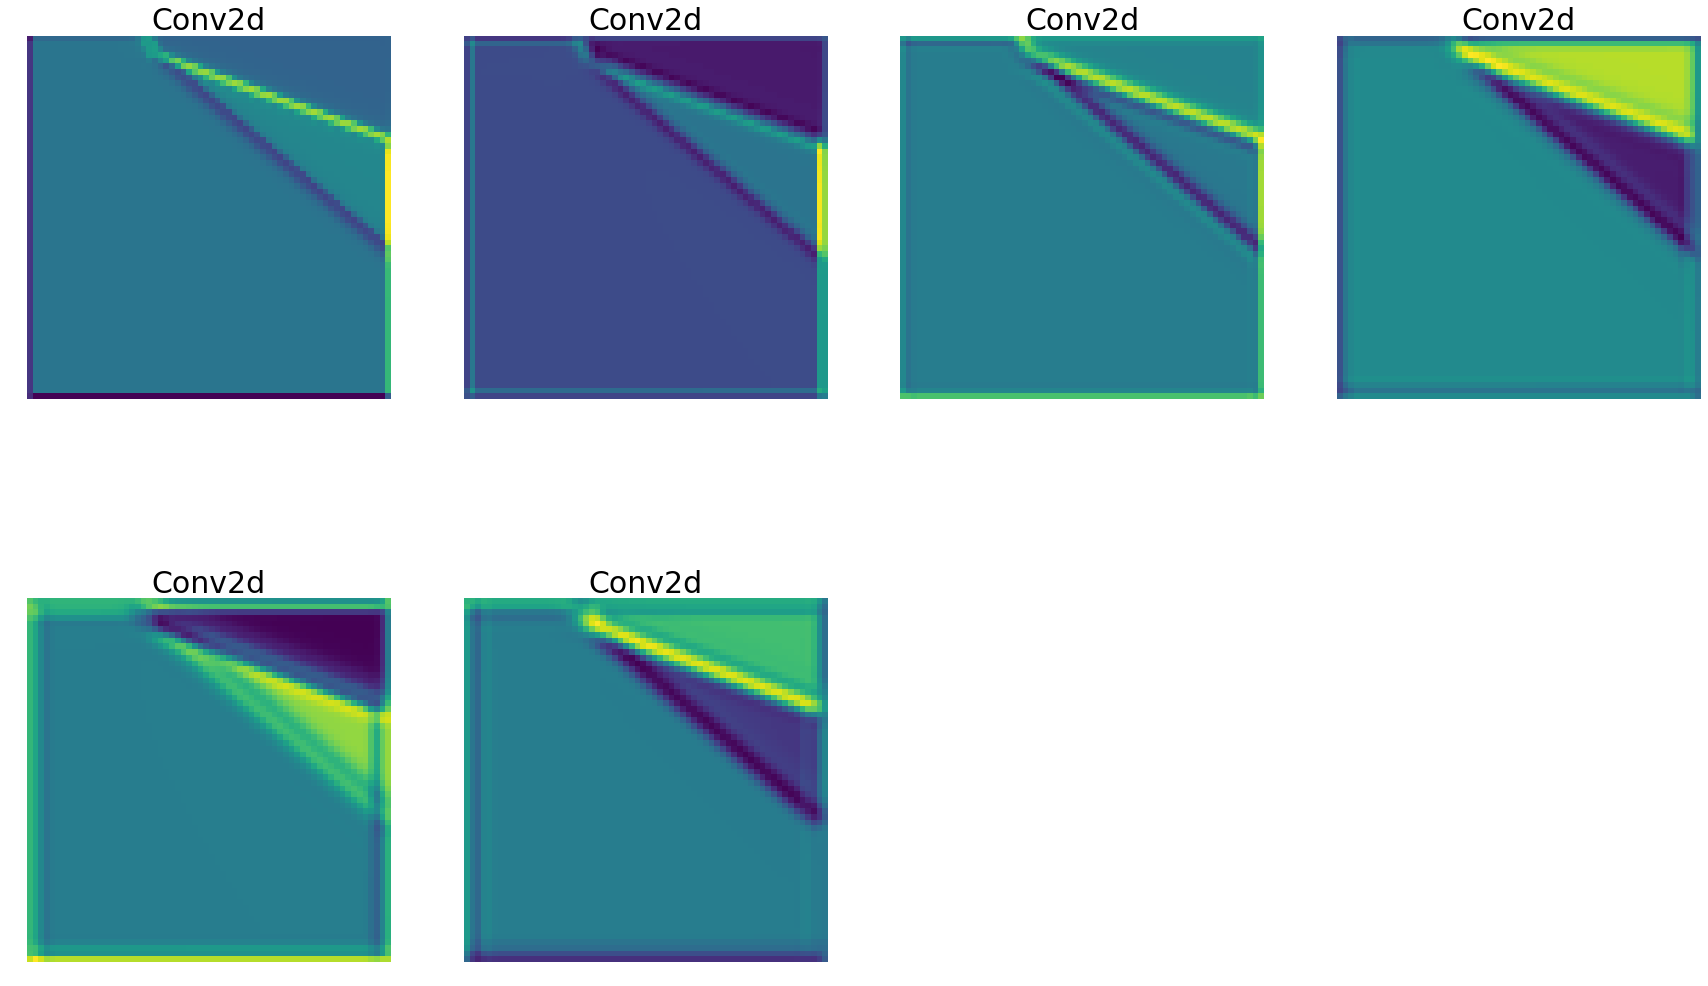

In [181]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

## Next, try to learn vertex and junction angles, where angles are between 0 and 2*pi and vertex is between [-1,1] x [-1,1]

In [187]:
class junctionNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128, 128)   
        self.fc2 = nn.Linear(128, 5)   
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        x = F.relu(self.maxpool(x))
        x = self.conv6(x)
        x = F.relu(self.maxpool(x))
        x = x.view(-1,128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
#         x = torch.cat([,])
        
        out1 = 2*np.pi*torch.sigmoid(x[:,:3])
        out2 = 2*torch.sigmoid(x[:,3:])-1
        
        return out1, out2
    
def center_loss(output, target):
    return torch.sqrt(torch.sum((output - target)**2))

def junction_loss(output, target):
    return torch.sqrt(torch.sum((output - target)**2))

def weight_reset(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


In [188]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = junctionNet()
model = model.to(device)
# model.apply(weight_reset)

summary(model, input_size=(1, 64, 64))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]         147,584
         MaxPool2d-8            [-1, 128, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         147,584
        MaxPool2d-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 128, 2, 2]         147,584
        MaxPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                  [-1, 128]          16,512
           Linear-14                   

In [189]:
n_epochs = 150

model.train();

# loss_over_time = [] # to track the loss as the network trains
# test_loss_over_time = []

for epoch in range(0,n_epochs):  # loop over the dataset multiple times

    if epoch == 0:
        loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    running_loss = 0.0

    for batch_i, data in enumerate(train_loader):
        # get the input images and their corresponding labels

        inputs, labels, _ = data
    
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()

        # forward pass to get outputs
        out1, out2 = model(inputs)

        # calculate the loss
#         loss = criterion(outputs, labels)
        loss1 = center_loss(out2,labels[:,3:])
        loss2 = junction_loss(out1,labels[:,:3])
        loss = loss2 # + loss1
        
#         print(loss1)
#         print(loss2)
        
#         sys.quit()

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # print loss statistics
        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()

#         if batch_i % 1000 == 999:    # print every 1000 batches
#             avg_loss = running_loss/1000
#             # record and print the avg loss over the 1000 batches
#             loss_over_time.append(avg_loss)
#             print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
#             running_loss = 0.0

    # Calculate test data loss:
    with torch.no_grad():
        # log scalars
        for batch_i, data in enumerate(test_loader):
            
            inputs_test, labels_test, _ = data
            inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)           
            pred_test = model(inputs_test)
            test_loss = junction_loss(out1,labels[:,:3]) # + center_loss(out2,labels[:,3:]) + 
            test_loss_over_time.append(test_loss)
    
#     if epoch % 10 == 0:
#         plt.figure()
#         plt.plot(test_loss_over_time)
#         plt.show()

    # Calculate model loss:
    avg_loss = running_loss/data_size
    # record and print the avg loss over the 1000 batches
    loss_over_time.append(avg_loss)
    print('Epoch: {}, Avg. Loss: {}, Test Loss: {}'.format(epoch + 1, avg_loss, test_loss))
    

print('Finished Training')

Epoch: 1, Avg. Loss: 0.8513107465744019, Test Loss: 9.578250885009766
Epoch: 2, Avg. Loss: 0.7526473198890686, Test Loss: 8.60084342956543
Epoch: 3, Avg. Loss: 0.7374885451316834, Test Loss: 7.486079692840576
Epoch: 4, Avg. Loss: 0.7323511500358582, Test Loss: 9.331719398498535
Epoch: 5, Avg. Loss: 0.7299135485649109, Test Loss: 8.287665367126465
Epoch: 6, Avg. Loss: 0.7277338230133057, Test Loss: 6.710868835449219
Epoch: 7, Avg. Loss: 0.7255238631248474, Test Loss: 6.75799036026001
Epoch: 8, Avg. Loss: 0.725251485824585, Test Loss: 7.940917491912842
Epoch: 9, Avg. Loss: 0.7249192210197448, Test Loss: 7.432379722595215
Epoch: 10, Avg. Loss: 0.7243774125099182, Test Loss: 8.852688789367676
Epoch: 11, Avg. Loss: 0.7225670074462891, Test Loss: 8.574457168579102
Epoch: 12, Avg. Loss: 0.7231545826911926, Test Loss: 7.609747886657715
Epoch: 13, Avg. Loss: 0.7223237277030945, Test Loss: 7.184725761413574
Epoch: 14, Avg. Loss: 0.7223928533554077, Test Loss: 8.622812271118164
Epoch: 15, Avg. Lo

Epoch: 116, Avg. Loss: 0.08525999219417572, Test Loss: 1.2053987979888916
Epoch: 117, Avg. Loss: 0.08182045767307282, Test Loss: 1.0970426797866821
Epoch: 118, Avg. Loss: 0.08188486976623535, Test Loss: 1.1230367422103882
Epoch: 119, Avg. Loss: 0.08090944455862045, Test Loss: 0.9803307056427002
Epoch: 120, Avg. Loss: 0.08024250906705856, Test Loss: 0.8452784419059753
Epoch: 121, Avg. Loss: 0.07732369799613953, Test Loss: 0.7276486158370972
Epoch: 122, Avg. Loss: 0.07611139359474182, Test Loss: 0.7692269086837769
Epoch: 123, Avg. Loss: 0.0762450984597206, Test Loss: 0.7047425508499146
Epoch: 124, Avg. Loss: 0.07569423946142197, Test Loss: 0.6335713863372803
Epoch: 125, Avg. Loss: 0.07581869354248047, Test Loss: 0.6383550763130188
Epoch: 126, Avg. Loss: 0.07373271951675416, Test Loss: 0.7235463857650757
Epoch: 127, Avg. Loss: 0.07056980476975441, Test Loss: 0.6960976719856262
Epoch: 128, Avg. Loss: 0.06982171266674995, Test Loss: 0.8914117813110352
Epoch: 129, Avg. Loss: 0.07046761366724

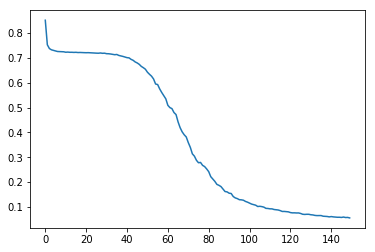

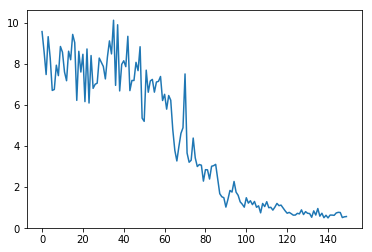

In [190]:
plt.figure()
plt.plot(loss_over_time)


plt.figure()
plt.plot(test_loss_over_time)


In [192]:
# What should the outputs look like? 

model.eval();

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, labels, _ = data
    
    inputs, labels = inputs.to(device), labels.to(device)

    # forward pass to get outputs
    out1,out2 = model(inputs)
    
    out1 = out1.squeeze().detach().cpu()
    out2 = out2.squeeze().detach().cpu()
    
    gt = labels.cpu().squeeze()


tensor([309.0648, 322.6951,  95.9334])
tensor([ 38.2531,  88.2093, 336.5325])
tensor([ 96.3939,  80.2300, 151.4858])
tensor([199.1483, 259.2852, 201.6130])
tensor([167.9401, 251.3646, 130.8755])
tensor([115.4101, 131.6767, 221.1029])
tensor([110.6476, 284.3520, 100.6767])
tensor([197.7618, 177.0988, 187.2107])
tensor([204.3731, 240.7546, 317.0139])
tensor([109.5767, 167.0033, 249.4025])


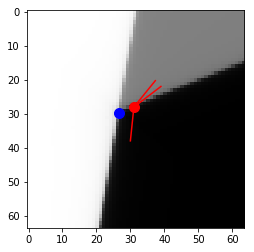

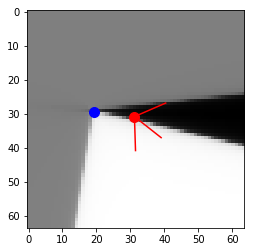

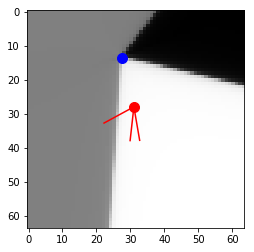

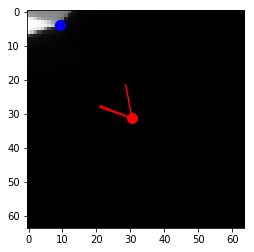

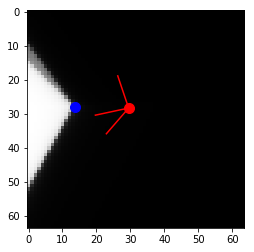

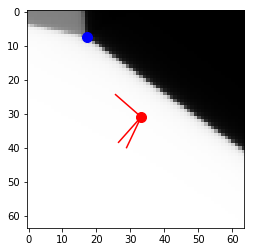

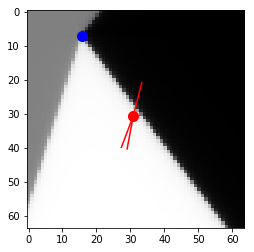

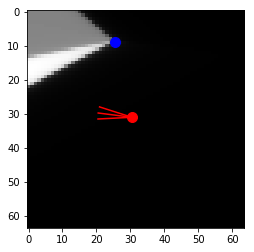

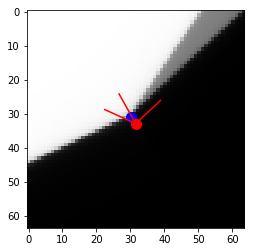

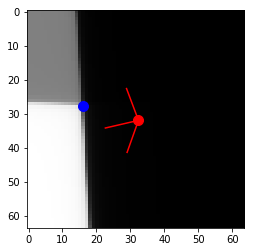

In [201]:
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_output_unscaled = out2[ii]
    center_output = center_output_unscaled*32+32
    center_gt = gt[ii][3:]*32 + 32
    
    
    print(torch.rad2deg(out1[ii]))
    
    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([np.cos(out1[ii][0]),np.sin(out1[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([np.cos(out1[ii][1]),np.sin(out1[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([np.cos(out1[ii][2]),np.sin(out1[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')

### Aside: You can use polynomials to create a permutation invariant loss

### (x-a)(x-b)(x-c) = x^3 + .... => have the network output polynomial coefficents and then solve for a, b, and c

In [1]:
# Next, field of junctions with permutation-invariant loss

# First we need to define a polynomial solver:

def quadfcn_opt4(a, b, c):
    if (a == 0):
        if (b == 0):
              x = []
        else:
            x = -c/b
    else:
        nroot = 2
        DD = b*b-4*a*c
        if (DD >= 0):
            x = np.zeros(2)
            x[0] = (-b+np.sqrt(DD))/2/a
            x[1] = (-b-np.sqrt(DD))/2/a
        else:
            x = [];
    return x, nroot


def cubicfcnroots_opt4(a,b,c,d):

    # Step 0: If a is 0 use the quadratic formula. -------------------------
    if (a == 0.):
        x, nroot = quadfcn_opt4(b, c, d)
        return x

    # Cubic equation with 3 roots
    nroot = 3

    # Step 1: Calculate p and q --------------------------------------------
    p  = c/a - b*b/a/a/3.
    q  = (2.*b*b*b/a/a/a - 9.*b*c/a/a + 27.*d/a) / 27.

    # Step 2: Calculate DD (discriminant) ----------------------------------
    DD = p*p*p/27. + q*q/4.

    # Step 3: Branch to different algorithms based on DD -------------------
    if (DD < 0.):
        # Step 3b:
        # 3 real unequal roots -- use the trigonometric formulation
        phi = np.arccos(-q/2./np.sqrt(np.abs(p*p*p)/27.))
        temp1 = 2.*np.sqrt(abs(p)/3.)
        y1 =  temp1*np.cos(phi/3.)
        y2 = -temp1*np.cos((phi+np.pi)/3.)
        y3 = -temp1*np.cos((phi-np.pi)/3.)
    else:
        # Step 3a:
        # 1 real root & 2 conjugate complex roots OR 3 real roots (some are equal)
        temp1 = -q/2. + np.sqrt(DD)
        temp2 = -q/2. - np.sqrt(DD)
        u = np.abs(temp1)**(1./3.)
        v = np.abs(temp2)**(1./3.)
        if (temp1 < 0.):
            u=-u
        if (temp2 < 0.):
            v=-v
        y1  = u + v
        y2r = - y1 /2.
# %         y2i =  (u-v)*sqrt(3.)/2.;

    # Step 4: Final transformation -----------------------------------------
    temp1 = b/a/3.
    y1 = y1-temp1
    if (DD < 0.):
        y2 = y2-temp1
        y3 = y3-temp1
    else:
        y2r=y2r-temp1

    # Assign answers -------------------------------------------------------
    if (DD < 0.):
        x = np.array([[y1],[y2],[y3]])
    elif (DD == 0.):
        x = np.array([[y1],[y2r],[y2r]])
    else:
        x = np.array([[y1]])

    return x